# Implementacion algoritmo de clustering: OPTICS

### Equipo 11  
<ul>
  <li>Guillermo Arredondo (197256)</li>
  <li>Iñaki Fernandez (195421)</li>
  <li>Mauricio Vazquez (191686)</li>
</ul>

## Descripción

<li>OPTICS, por sus siglas en ingles (Ordering Puntos To Identify the Clustering Structure), es un algoritmo de clustering o agrupamiento, en español, basado en la densidad que se utiliza para identificar la estructura de los clusters o agrupamientos en datos en una dimension alta. Es un complemento a DBSCAN, ya que como tal no es un metodo de agrupamiento. Por otro lado, produce una ordenacion de datos que se puede usar para identificar los grupos basados en la densidad en multiples niveles de granularidad.</li>

<br>

<li> Fue creado por el mismo grupo de investigación que DBSCAN, es decir, por Ankerst, Mihael, and Markus (1999).</li>

<br>

<li> Generalmente, es utilizado como preprocesamiento de datos y para una exploración primaria de las distribuciones de los datos. </li>

<br>

<li> Su principal ventaja es que no requiere hiperparametros para la clusterizacion. Aunque, en general, se definen los valores de mínimo de puntos por cluster y máximo radio a considerar </li>

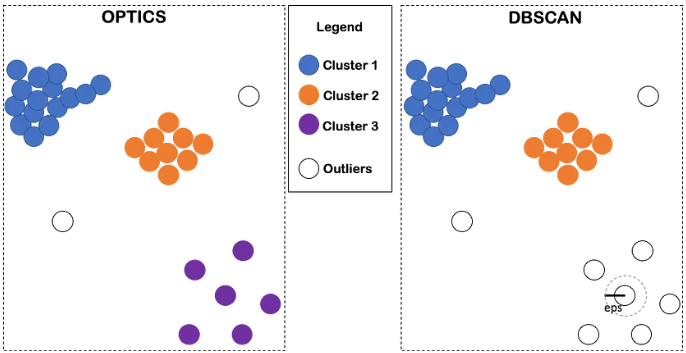

In [164]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt

In [165]:
# Clase auxiliar punto
class Punto:
    '''
    Clase auxiliar punto; ayuda a la visualización del algoritmo al definir cada punto por las tres propiedades principales para el algoritmo
    coords: Coordenadas específicas del punto 
    alcance: Propiedad que permite identificar la distancia de alcance (reachability-distance) de cada uno de los puntos
    visitado: Propiedad que permite conocer si el punto ya fue visitado anteriormente (auxiliar en eficiencia del algoritmo)
    '''
    def __init__(self, coordinates):
        self.coordinates = coordinates
        self.alcance = None
        self.visitado = False

# Clase de clustering por algoritmo OPTICS
class myOPTICS:
    '''
    Clase para utilizar el modelo OPTICS clásico; en el cual se agregan algunas funciones auxiliares por practicidad.
    Asimismo se agrega una función extra que permita al algoritmo generar los agrupamientos de los datos de forma específica
    previniendo así, errores por parte del usuario en el momento de interpretar los resultados del algoritmo OPTICS
    Parámetros: 
        min_pts: número mínimo de puntos para considerar un cluster como significante
        max_radio: valor del máximo radio (epsilon) con el cual considerar una distancia cercana a un punto
    Atributos:
        data: conjunto de datos aportado en la clase Fit y al cual se desea obtener su estructura de agrupación
        order_list: lista ordenada sobre la jerarquización considerada por el algoritmo
        clases: lista con las clases a las que pertenece cada una de las observaciones
    '''
    
    def __init__(self, min_pts, max_radio):
        if min_pts <2:
            Exception('No se puede porque no se podria clusterizar con 1 punto. Tendrias clusters de 1 punto.')
        else:
            self.min_pts  = min_pts 
            self.max_radio = max_radio
            self.order_list = [] 

    def distancia(self, p1, p2):
        '''Podrian implementarse con distintas metricas; en este caso se utiliza la norma euclidiana'''
        return np.linalg.norm(p1.coordinates - p2.coordinates)

    
    def get_vecinos(self, p, v_data):
        '''Función que permite obtener la vecindad del punto p que cumpla estar a menor distancia que el max_radio'''
        vecinos = []
        for q in v_data:
            d = self.distancia(p, q)
            if d <= self.max_radio:
                vecinos.append(q)
        return vecinos
    

    def distancia_centro(self, p, v_data):
        '''Función que busca actualizar las distancias al nucleo del cluster definido en ese momento'''
        vecinos = self.get_vecinos(p, v_data)
        if len(vecinos) >= self.min_pts :
            distancias = sorted([self.distancia(p, q) for q in vecinos])
            return distancias[self.min_pts  - 1]
        return None
    

    def myOrder(self, p):
            '''Función auxiliar para establecer un orden dentro de una lista de clases puntos'''
            if p.alcance is None:
                value = np.inf
            else:
                value = p.alcance
            return value
    

    def actualiza(self, vecinos, p, hijos):
        '''Actualizar la lista de hijos (que sirve a modo de PriorityQueue)'''
        core_dist = self.distancia_centro(p, vecinos)
        if core_dist is not None:
            for q in vecinos:
                if not q.visitado:
                    alcance_aux = max(core_dist, self.distancia(p, q))
                    if q.alcance is None:
                        q.alcance = alcance_aux
                        hijos.append(q)
                    else:
                        if alcance_aux < q.alcance:
                            q.alcance = alcance_aux
        hijos.sort(key=self.myOrder) #ordenamos la lista de hijos de acuerdo a su alcance


    def data_punto(self, data):
        '''Funcion destinada a convertir un ndarray a una lista con elementos de la clase Punto'''
        return [Punto(elem) for elem in data]


    def fit(self,data):
        '''
        Funcion que sirve para entrenar el modelo OPTICS a través de un conjunto de datos específicos.
        '''
        self.data = self.data_punto(data)

        # Paso 1: Colocar a todos los puntos un valor de indefinido (en estos casos puede optarse por poner el valor de infinito por igual)
        for p in self.data:
            p.alcance = None

        # Paso 2: iteramos sobre todo el conjunto de datos no visitados aún
        # Para lograr esto se utiliza un condicional para que en el caso de ya haberse visitado saltarse dicha iteración 
        for p in self.data:
            if p.visitado:
                continue
            
            #Paso 3: obtenemos la vecindad de interés del punto 
            vecinos = self.get_vecinos(p, self.data)
            p.visitado = True
            self.order_list.append(p)

            # Paso 4: actualizamos la distancia al centro y checamos si es indefinida
            #           Definimos una lista "hijos" donde almacenemos los vecinos cercanos a considerar y ordenar de acuerdo a la menor distancia
            #           Cada uno de estos hijos se visita para ir construyendo el cluster a partir del círculo más cercano para cada uno
            #           De acuerdo a este orden se van marcando cada punto como visitado y se agregan al atributo order_list
            core_dist = self.distancia_centro(p, self.data)
            if core_dist is not None:
                hijos = []
                self.actualiza(vecinos, p, hijos)

                # Como puede notarse no se hace uso de un PriorityQueue, de lo contrario aquí deberías iterar de acuerdo al hijo con la menor distancia
                #   sin embargo, usamos un ordenamiento de la lista hijos de acuerdo a la función myOrder (auxiliar) que permite ordenar de acuerdo al
                #   valor de alcanzabilidad de los puntos existentes en la vecindad.
                while hijos:
                    q = hijos.pop(0)
                    q_vecinos = self.get_vecinos(q, self.data)
                    q.visitado = True
                    self.order_list.append(q)
                    if self.distancia_centro(q, self.data) is not None:
                        self.actualiza(q_vecinos, q, hijos)


    def get_clases(self):
        '''
        Función extra que permite generar las clases de los datos (algoritmo de agrupamiento) a partir de los
        datos obtenidos por el algoritmo OPTICS y sus medidas de alcanzabilidad para cada punto.
        Para efectos prácticos, los puntos considerados como outliers se denominan con la clase -1.
        Se obtiene una lista de las clases conservando el orden proporcionado por el atributo self.order_list
        '''
        clase = 0
        self.clases = []

        # Considerando que sin importar la organización de los datos, el primer dato siempre recibirá un valor de alcanzabilidad no definida
        #   iteramos a partir del segundo punto en la lista de jerarquización.
        # Para cada uno de los puntos conseguimos el siguiente y seguimos la siguiente regla de asignación:
        #   En caso de tener dos alcances no definidos contiguos, entonces el primero de ellos es un outlier
        #   En el rango de alcances [no definido, no definido) se agrupan las distintas clases (nótese que el conjunto es inclusivo al inicio y exclusivo al final)
        # El siguiente código asigna la clase correspondiente a cada punto a partir del valor del siguiente dato en la lista ordenada
        for i in range(1, len(self.order_list)):
            p = self.order_list[i]
            ant = self.order_list[i-1]
 
            if p.alcance is None and ant.alcance is None:
                self.clases.append(-1)
            elif p.alcance is None:
                self.clases.append(clase)
                clase += 1
            else:
                self.clases.append(clase)   
        
        ultimo = self.order_list[-1] 
        if ultimo.alcance is None:
            self.clases.append(-1)
        else:
            self.clases.append(clase)          


### Datos importantes a considerar: 

En general, una gran ventaja del algoritmo de OPTICS original es la utilización de una estructura de orden como son MinHeap o PriorityQueue con lo que se asegure que en cada punto se esté utilizando la distancia más cercana respecto al punto de nucleo referido. Sin embargo, el algoritmo presentado para OPTICS en el código anterior no hace uso de ninguna de estas estructuras debido a la complejidad de diseñar dicha estructura apta para conservar las características del punto con la distancia mínima (coordenadas, índice, si está visitado o no, etc), pero establece una funcionalidad análoga a una PriorityQueue a través de una lista que es ordenada; sin embargo, no se asegura ir en el orden de distancias descendente. Para ello habría que asegurar que la lista definida como vecinos estuviera en orden de distancias descendente.

**Proceso del algoritmo OPTICS**

El algoritmo consta del siguiente procedimiento: 

1. Se elige un punto que se considerará como punto de centro; a este punto se obtiene la distancia mínima con la cual se pueda considerar como un cluster, para ello es necesario usar la función *get_vecinos* y posteriormente usar la función *distancia_centro* con ello se asegura que el área local de este punto es relevante de analizar para encontrar los componentes del cluster. 
2. Recorremos cada uno de los puntos dentro de la vecindad definida en el punto anterior, y repetimos el proceso, así obtenemos aquellos puntos que se encuentren a una distancia *relativamente* pequeña del punto anterior (esta es una característica importante de OPTICS, pues a diferencia de DBSCAN no considera las distancias de acuerdo a un valor fijo alrededor de los puntos núcleo, sino que es una distancia relativa al ambiente local del punto; esto permite mejorar la clusterización aún con distintas densidades de los grupos). Con ello, volvemos a obtener la correspondiente lista de puntos de vecindad de los vecinos que se encuentren a suficiente cercanía. Con ello, ampliamos el rango del cluster.
3. Una vez concluida la lista de vecindad completa de dicho cluster obtenemos el siguiente punto con alcanzabilidad indefinida, con lo cual aseguramos estudiar el nuevo cluster disponible. 

La siguiente imagen puede representar apropiadamente el proceso de recorrido elaborado durante el algoritmo:
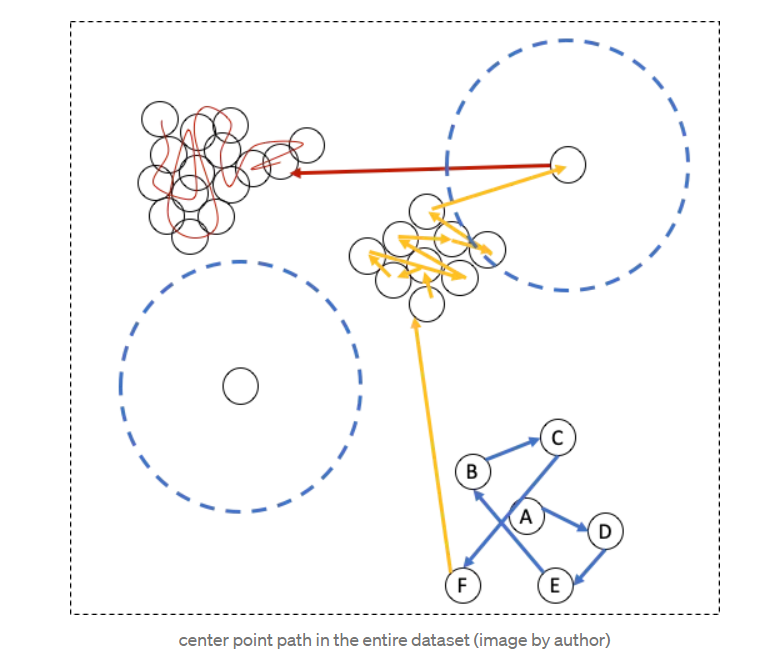

Una vez concretado el procedimiento mencionado anteriormente, dentro del cual se actualizan las distancias de alcance, el algoritmo regresa una lista ordenada de los puntos de acuerdo a la jerarquización de importancia de los puntos (de acuerdo a su alcanzabilidad), en general se regresa o una lista de alcanzabilidades o un diagrama de alcanzabilidad (que es una variante de un dendrograma) 

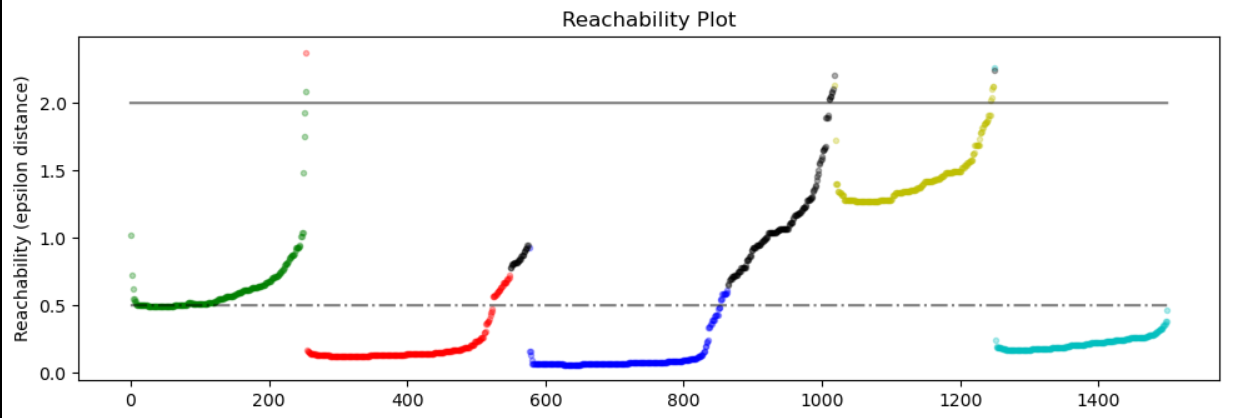

In [202]:
# Ejemplo de uso
T = np.array([[-1, 2], [-1, 4], [1, 0],
              [4, 2], [4, 4], [-4, 0],
              [4.5, 3], [2, 1], [0, -1],
              [10, 12], [4.8, 2.2], [3.5, 4.5],
              [-5, -6], [15.7, 10], [16.8, 9],
              [0,0], [-2, 1], [2, 1.5]])

# Instanciamos el modelo OPTICS con un máximo radio de 2 y puntos mínimos requeridos de 2
cluster_model = myOPTICS(max_radio =2, min_pts =2)

# Usamos la función fit
cluster_model.fit(T)

# Obtenemos la lista de los puntos ordenados en el orden de distancia jerarquica considerada por el algoritmo
# Es importante notar que siempre empieza en el primer punto, pero esto podría modificarse al agregar un random choice
#   y cuyo resultado no diferenciará la estructura de clusters de los datos 
order_list = cluster_model.order_list

# Obtenemos las clases con las que asociamos a cada punto a partir de la lista ordenada y sus valores de alcanzabilidad
cluster_model.get_clases()
clases = cluster_model.clases

print("COORDENADAS\t\tDISTANCIA DE ALCANCE\t\tCLASE")
for i, p in enumerate(order_list):
    if p.alcance is None:
        print(f'{p.coordinates};\t\t\t{p.alcance};\t\t\t {clases[i]}')
    else:
        print(f'{p.coordinates};\t\t\t{round(float(p.alcance),4)};\t\t\t {clases[i]}')

COORDENADAS		DISTANCIA DE ALCANCE		CLASE
[-1.  2.];			None;			 0
[-2.  1.];			1.4142;			 0
[-1.  4.];			2.0;			 0
[1. 0.];			None;			 1
[0. 0.];			1.0;			 1
[ 0. -1.];			1.0;			 1
[2. 1.];			1.4142;			 1
[2.  1.5];			0.5;			 1
[4. 2.];			None;			 2
[4.8 2.2];			0.8246;			 2
[4.5 3. ];			0.8544;			 2
[4. 4.];			1.118;			 2
[3.5 4.5];			0.7071;			 2
[-4.  0.];			None;			 -1
[10. 12.];			None;			 -1
[-5. -6.];			None;			 -1
[15.7 10. ];			None;			 3
[16.8  9. ];			1.4866;			 3


## Graficación de clusters obtenidos

Se presentan 4 gráficas en las cuales se puede reproducir los niveles de alcanzabilidad de cada uno de los puntos numerados iniciando en 0. Este es el resultado oficial de un análisis de clusters a través de OPTICS, con lo cual habría que considerar como clusters a todos aquellos "valles" representados en la gráfica de alcanzabilidad. Esto se debe a que la distancia de todos los primeros puntos de centro de los clusters tienen distancia indefinida, y todo lo encontrado entre dos valores indefinidos representa un cluster. Nótese que en la gráfica siguiente no pueden observarse los valores definidos como infito pues salen del rango

Entre la segunda y 4 gráfica podemos observar los puntos del conjunto de datos graficados con un color distinto de acuerdo a la clase a la que pertenecen de acuerdo a cada uno de los algortimos siguientes:
- OPTICS: definido por sklearn (importante notar que la diferencia respecto a nuestro algoritmo es que sklearn utiliza una modificación del algoritmo original de OPTICS para agregar el algoritmo de k vecinos cercanos, con lo cual puede asegura que el cluster sea lo más cerrado posible para definir el tamaño preciso de core distance mínima y similar a DBSCAN)
- myOPTICS: modelo de OPTICS implementado por nosotros
- DBSCAN: modelo definido por sklearn 

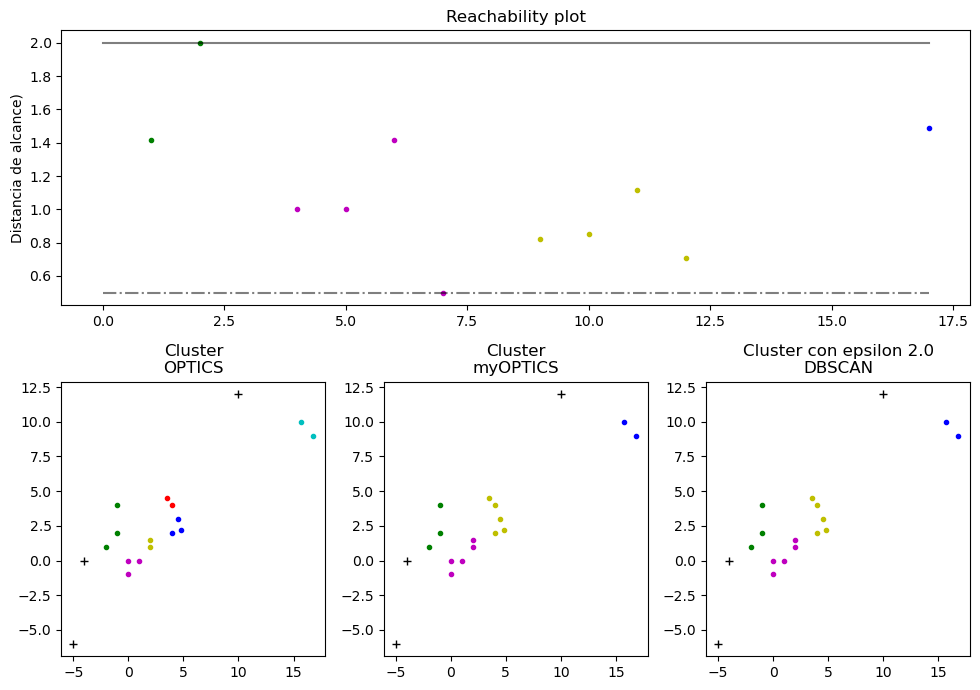

In [167]:
# Run the fit
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

clust = OPTICS(min_samples=2, xi=0.05, max_eps=2)
clust.fit(T)

labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

orden_coords = np.array([p.coordinates for p in order_list])

space = np.arange(len(T))
my_reachability = np.array([np.inf if p.alcance is None else p.alcance for p in order_list])
my_labels = np.array(clases)

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "m.", "y.", "b."]
for klass, color in zip(range(0, 4), colors):
    Xk = space[my_labels == klass]
    Rk = my_reachability[my_labels == klass]
    ax1.plot(Xk, Rk, color)
ax1.plot(space[my_labels == -1], my_reachability[my_labels == -1], "k.")
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha = 0.5)
ax1.set_ylabel("Distancia de alcance)")
ax1.set_title("Reachability plot")

# OPTICS
colors = ["g.", "m.", "y.", "b.", "r.", "c."]
for klass, color in zip(range(0, 6), colors):
    Xk = T[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color)
ax2.plot(T[clust.labels_ == -1, 0], T[clust.labels_ == -1, 1], "k+")
ax2.set_title("Cluster\nOPTICS")

# myOptics
colors = ["g.", "m.", "y.", "b."]
for klass, color in zip(range(0, 4), colors):
    Xk = orden_coords[my_labels == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color)
ax3.plot(orden_coords[my_labels == -1, 0], orden_coords[my_labels == -1, 1], "k+")
ax3.set_title("Cluster\nmyOPTICS")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "b."]
for klass, color in zip(range(0, 4), colors):
    Xk = T[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color)
ax4.plot(T[labels_200 == -1, 0], T[labels_200 == -1, 1], "k+")
ax4.set_title("Cluster con epsilon 2.0\nDBSCAN")

plt.tight_layout()
plt.show()

## Referencias:

- GeeksforGeeks. (2023). ML   OPTICS Clustering Implementing using Sklearn. GeeksforGeeks. https://www.geeksforgeeks.org/ml-optics-clustering-implementing-using-sklearn/ 
- sklearn.cluster.OPTICS. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html 
- Thakur, D. (2022, April 21). Machine Learning: All About OPTICS Clustering & Implementation in Python. Medium. https://dhavalthakur.medium.com/machine-learning-all-about-optics-clustering-implementation-in-python-85d7c76a23d5 
- Yufeng. (2022, January 29). Understanding OPTICS and Implementation with Python. Medium. https://towardsdatascience.com/understanding-optics-and-implementation-with-python-143572abdfb6